# Escolher algum ambiente

Foi escolhido como ambiente de estudo o '**Intersection**', disponível em: http://highway-env.farama.org/environments/intersection/

In [1]:
import aux_functions

STACK_SIZE = 4
SCALING = 1.75

env = aux_functions.intersection_v1(STACK_SIZE = STACK_SIZE, SCALING=SCALING)

In [2]:
env.reset()

for _ in range(40):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        obs, info = env.reset()
env.close()

## Observações no formato de imagem

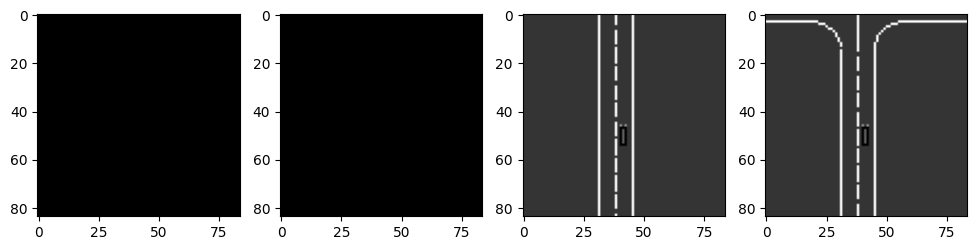

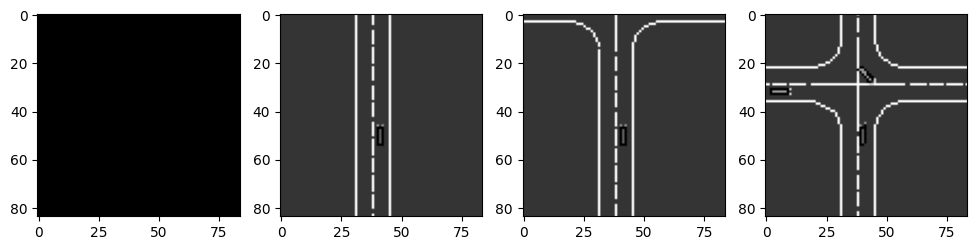

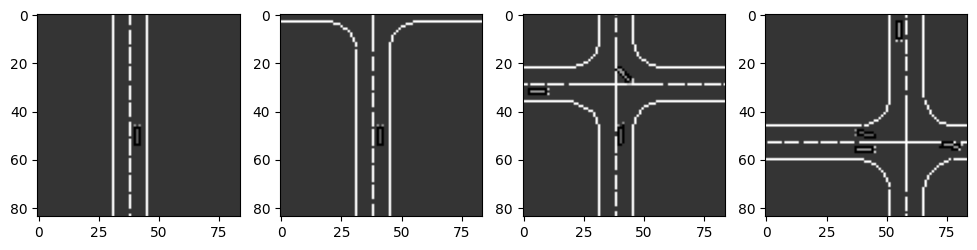

In [3]:
from matplotlib import pyplot as plt

env.reset()

for _ in range(3):
    obs, reward, done, truncated, info = env.step(env.action_space.sample())

    fig, axes = plt.subplots(ncols = STACK_SIZE, figsize=(12, 5))

    if STACK_SIZE > 1:
        for i, ax in enumerate(axes.flat):
            ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
    else:
        axes.imshow(obs[0, ...].T, cmap=plt.get_cmap('gray'))

plt.show()

# Escolher algoritmos

In [3]:
import tensorboard
%load_ext tensorboard

%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7176), started 2 days, 22:42:30 ago. (Use '!kill 7176' to kill it.)

In [4]:
import numpy as np

TOTAL_TIMESTEPS = 1_000_000 / 1000
LOG_INTERVAL = max(np.round(TOTAL_TIMESTEPS / 100), 1)
BUFFER_SIZE = 100_000

## DQN (baseline)

In [6]:
from stable_baselines3 import DQN

env.reset()

ddpg = DQN("CnnPolicy", env, verbose=0, buffer_size=BUFFER_SIZE, tensorboard_log="logs")
ddpg.learn(total_timesteps=TOTAL_TIMESTEPS, log_interval=LOG_INTERVAL, progress_bar=True)
ddpg.save("dqn_intersection")

Output()

In [7]:
# from stable_baselines3 import DQN
dqn = DQN.load("dqn_intersection")

aux_functions.render_model(dqn, env)

## PPO (state of art)

### Otimização de hiper-parâmetros

In [5]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

TOTAL_TIMESTEPS_OPTUNA = 6144 #100_000
LOG_INTERVAL_OPTUNA = max(np.round(TOTAL_TIMESTEPS_OPTUNA / 100), 1)
N_EVAL_EPISODES = 100

def train_sac_intersection(trial : optuna.Trial):
    # Parametros de teste
    lr = trial.suggest_categorical('learning_rate', [0.00015, 0.0003, 0.00045]) # learning rate for adam optimizer, the same learning rate will be used for
                                                                                # all networks (Q-Values, Actor and Value function) it can be a function of
                                                                                # the current progress remaining (from 1 to 0)
    ns = trial.suggest_categorical('n_steps', [1024, 2048, 3072])               # The number of steps to run for each environment per update
    ne = trial.suggest_categorical('n_epochs', [5, 10, 15])                     # Number of epoch when optimizing the surrogate loss

    # Ambiente de teste
    print(f"\nTRIAL #{trial.number}: {trial.params}")

    env = aux_functions.intersection_v1(STACK_SIZE = STACK_SIZE)
    env.reset()

    model = PPO("CnnPolicy", env,
                learning_rate = lr,
                n_steps = ns,
                n_epochs = ne,
                verbose = 0, tensorboard_log = 'logs')
    model.learn(total_timesteps = TOTAL_TIMESTEPS_OPTUNA, log_interval = LOG_INTERVAL_OPTUNA, progress_bar = True)

    env.reset()

    results = evaluate_policy(model, env, n_eval_episodes=N_EVAL_EPISODES)

    env.close()

    return results[0]

In [6]:
study = optuna.create_study(direction = "maximize",
                            storage = 'sqlite:///sac_optimization.db',
                            study_name = 'sac_intersection_v1',
                            # study_name = 'teste',
                            load_if_exists = True)

N_TRIALS = 10
study.optimize(train_sac_intersection, n_trials = N_TRIALS)

print("MELHORES PARÂMETROS:")
print(study.best_params)

[I 2024-03-01 11:51:23,616] Using an existing study with name 'teste' instead of creating a new one.


MELHORES PARÂMETROS:
{'learning_rate': 0.00015, 'n_steps': 1024, 'n_epochs': 15}


In [14]:
# import os
# import optuna

# os.cpu_count()
# optuna.delete_study(study_name = 'teste', storage = 'sqlite:///sac_optimization.db')

### Treinamento

In [7]:
study.best_params

{'learning_rate': 0.00015, 'n_steps': 1024, 'n_epochs': 15}

In [8]:
env.reset()

lr = study.best_params['learning_rate']
ns = study.best_params['n_steps']
ne = study.best_params['n_epochs']

ppo = PPO("CnnPolicy", env,
                learning_rate = lr,
                n_steps = ns,
                n_epochs = ne,
                verbose=0, tensorboard_log="logs")
ppo.learn(total_timesteps=TOTAL_TIMESTEPS, log_interval=LOG_INTERVAL, progress_bar=True)
ppo.save("ppo_intersection")

Output()

In [9]:
# from stable_baselines3 import PPO
ppo = PPO.load("ppo_intersection")

aux_functions.render_model(ppo, env)

# Outros

In [ ]:
# model = SAC.load("sac_intersection")
# model.policy

/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.56GB > 2.39GB
  warnings.warn(


CnnPolicy(
  (actor): Actor(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3072, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=256, out_features=2, bias=True)
    (log_std): Linear(in_features=256, out_features=2, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4

In [ ]:
# model = DDPG.load("ddpg_intersection")
# model.policy

/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.56GB > 2.24GB
  warnings.warn(


CnnPolicy(
  (actor): Actor(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3072, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (mu): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=2, bias=True)
      (5): Tanh()
    )
  )
  (actor_target): Actor(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kerne